Notebook used together with the generic code analysis to plot our results.

In [1]:
import sys,os
#import uproot as uproot
#import awkward1 as ak
import json
import numpy as np
import matplotlib.pyplot as plt
#from fcc_python_tools.locations import loc
#from fcc_python_tools import kinematics_flat
from particle import literals as lp
#from fcc_python_tools import plotting
#import tensorflow as tf
#import zfit
import random
import ROOT
import matplotlib.ticker as tick
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

parameters = {'axes.labelsize': 25,
          'axes.titlesize': 30, 'xtick.labelsize':20,'ytick.labelsize':20, 'figure.titlesize':23, 'legend.fontsize':20 }
plt.rcParams.update(parameters)

rand=0

Welcome to JupyROOT 6.26/10


In [2]:
import xgboost as xgb
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import pandas as pd
from scipy.stats import ks_2samp

# 1 Prepare dataframe for XGBoost

In [3]:
#0, 0.5, 0.8
probPI0=0.8#0, 0.5, 0.8

SAVEMOD="no"#"yes""no"

eff_vertexing=0.8

In [4]:
listmod=["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
listvar=["B_FD","eff_reco","eff_pred_sel","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]
listsmearing=["20-3"]
for i in ["++","--","+-","-+","sel"]:
    listvar.append(f"{i}")

data={}
for mode in listmod:
    for smearing in listsmearing:
        data1={}
        for var in listvar:
            data1[var]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_{var}.txt")
        #adding the p_tau reco variables
        for tau in ["1","2"]:
            data1[f"sel_P_tau_{tau}"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_{tau}_sel.txt")
        for i in ["++","+-","-+","--"]:
            data1[f"{i}_P_tau_1"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_1_{i[0]}.txt")
            data1[f"{i}_P_tau_2"]=np.loadtxt(f"data_for_sel/{smearing}/{mode}_P_tau_2_{i[1]}.txt")       
        data[f"{mode}_{smearing}"]= data1

#eff to obtain a RP candidate wrt the number of event generated and combination of reco efficiency with neutrino method if needed
for mode in listmod:
    for smearing in listsmearing:
        if ((mode=="sig")):
            maxevents=100000
        else:
            maxevents=400000
            data[f"{mode}_{smearing}"][f"eff_reco"][0]=(data[f"{mode}_{smearing}"][f"eff_reco"][0]+data[f"{mode}_{smearing}"][f"eff_reco"][2]+data[f"{mode}_{smearing}"][f"eff_reco"][4]+data[f"{mode}_{smearing}"][f"eff_reco"][6])/4
            data[f"{mode}_{smearing}"][f"eff_reco"][1]=np.sqrt(data[f"{mode}_{smearing}"][f"eff_reco"][1]**2+data[f"{mode}_{smearing}"][f"eff_reco"][3]**2+data[f"{mode}_{smearing}"][f"eff_reco"][5]**2+data[f"{mode}_{smearing}"][f"eff_reco"][7]**2)/4
        data[f"{mode}_{smearing}"][f"eff_RP_candidates"]=len(data[f"{mode}_{smearing}"][f"--"])/maxevents
        data[f"{mode}_{smearing}"][f"eff_RP_candidates_err"]=np.sqrt(data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*(1-data[f"{mode}_{smearing}"][f"eff_RP_candidates"])/maxevents)
        #print(smearing, mode, data[f"{mode}_{smearing}"][f"eff_RP_candidates"])

#add of a var to have class (sig or bkg) for each event and the decay mode on the same principle:
for mode in listmod:
    for smearing in listsmearing:
        data[f"{mode}_{smearing}"]["decay_mode"]=np.array([f'{mode}']*len(data[f"{mode}_{smearing}"]["--"]))
        if (mode=="sig"):
            data[f"{mode}_{smearing}"]["class"]=np.array(['sig']*len(data[f"{mode}_{smearing}"]["--"]))
        else:
            data[f"{mode}_{smearing}"]["class"]=np.array(['bkg']*len(data[f"{mode}_{smearing}"]["--"]))
#print(data[f"sig_{smearing}"]["class"])
#print(len(data[f"sig_{smearing}"]["class"]))

#to build all version by concatenate the +/- solution and duplicate 4 times the previous variables
for mode in listmod:
    for smearing in listsmearing:
        data[f"{mode}_{smearing}"][f"all"]=np.concatenate((data[f"{mode}_{smearing}"][f"++"],data[f"{mode}_{smearing}"][f"+-"],data[f"{mode}_{smearing}"][f"-+"],data[f"{mode}_{smearing}"][f"--"]))
        data[f"{mode}_{smearing}"][f"all_P_tau_1"]=np.concatenate((data[f"{mode}_{smearing}"][f"++_P_tau_1"],data[f"{mode}_{smearing}"][f"+-_P_tau_1"],data[f"{mode}_{smearing}"][f"-+_P_tau_1"],data[f"{mode}_{smearing}"][f"--_P_tau_1"]))
        data[f"{mode}_{smearing}"][f"all_P_tau_2"]=np.concatenate((data[f"{mode}_{smearing}"][f"++_P_tau_2"],data[f"{mode}_{smearing}"][f"+-_P_tau_2"],data[f"{mode}_{smearing}"][f"-+_P_tau_2"],data[f"{mode}_{smearing}"][f"--_P_tau_2"]))
        for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]:
            data[f"{mode}_{smearing}"][f"all_{var}"]=np.concatenate((data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"],data[f"{mode}_{smearing}"][f"{var}"]))


In [5]:
listmod=["sig","Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
BF_list={"sig":9.57*10**(-11),"Bd2KstDsDsDs2TauNu":1.14*10**(-10),"Bd2KstDsDsDs2pipipipi0":1.45*10**(-10),"Bd2KstDsTauNuDs2TauNu":3.59*10**(-10),"Bd2KstDsDsDs2pipipipi0pi0":1.02*10**(-8),"Bd2KstDsstDsDsst2DsgammaDs2Taunu":3.60*10**(-10),"Bd2KstDsDsDs2TaunuDs2pipipipi0":1.28*10**(-10), "Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0":7.51*10**(-9),"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0":1.08*10**(-9), "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0":3.22*10**(-8)}
# "Bd2KstDsstDsDsst2DsgammaDs2Taunu":1.83*10**(-9)*0.935 from BF(Dsstar->Ds gamma)
#obtain mass in plot window, in cut study window and the associated eff
for mode in listmod:
    for smearing in listsmearing:
        for i in ["sel","all"]:
                data[f"{mode}_{smearing}"][f"{i}_no_0"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}"]!=0]
                data[f"{mode}_{smearing}"][f"{i}_in_window"]=((data[f"{mode}_{smearing}"][f"{i}_no_0"]<6)*((data[f"{mode}_{smearing}"][f"{i}_no_0"]>4.6)))
                data[f"{mode}_{smearing}"][f"{i}_eff_plot_window"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_in_window"])/len(data[f"{mode}_{smearing}"][f"{i}_no_0"])
                #print(data[f"{mode}_{smearing}"][f"{i}_eff_window"])
                data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]=(data[f"{mode}_{smearing}"][f"{i}"]!=0)*(data[f"{mode}_{smearing}"][f"{i}"]>4.6)*(data[f"{mode}_{smearing}"][f"{i}"]<6)
                data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=6*(10**12)*BF_list[f"{mode}"]*data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*data[f"{mode}_{smearing}"][f"eff_reco"][0]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_window"]*eff_vertexing
                data[f"{mode}_{smearing}"][f"{i}_in_cut_window"]=((data[f"{mode}_{smearing}"][f"{i}_no_0"]<5.6)*((data[f"{mode}_{smearing}"][f"{i}_no_0"]>5)))
                data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_in_cut_window"])/len(data[f"{mode}_{smearing}"][f"{i}_no_0"])
                #if(i=="sel"): print("Eff to be in cut window for {} {} : {}".format(smearing,mode,data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]))
                data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]=(data[f"{mode}_{smearing}"][f"{i}"]!=0)*(data[f"{mode}_{smearing}"][f"{i}"]>5)*(data[f"{mode}_{smearing}"][f"{i}"]<5.6)
                data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=6*(10**12)*BF_list[f"{mode}"]*data[f"{mode}_{smearing}"][f"eff_RP_candidates"]*data[f"{mode}_{smearing}"][f"eff_reco"][0]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_window"]*eff_vertexing

#to obtain cuted variable w.r.t. the cut window study for each of the sol
for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi"]:
    for mode in listmod:
        for smearing in listsmearing:
            for i in ["sel","all"]:
                if (i=="all"):
                    add_var="all_"
                else:
                    add_var=""
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{add_var}{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{add_var}{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_P_tau_1"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_1"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_P_tau_1"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_1"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]
                data[f"{mode}_{smearing}"][f"{i}_cut_study_P_tau_2"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_2"][data[f"{mode}_{smearing}"][f"{i}_cut_cut_window"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_P_tau_2"]=data[f"{mode}_{smearing}"][f"{i}_P_tau_2"][data[f"{mode}_{smearing}"][f"{i}_cut_plot_window"]]

#to obtain weights to normalize each sample in cuts study plots  
for mode in listmod:
    for smearing in listsmearing:
        for i in ["sel","all"]:
            data[f"{mode}_{smearing}"][f"{i}_weights"]=np.ones(len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"]))/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"])

Cut study

In [6]:
for i in ["sel"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
        
for i in ["sel","all"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signinopi0=0
        for mode in listmod:
            if ((mode!="Bd2KstDsDsDs2pipipipi0")&(mode!="Bd2KstDsDsDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0")&(mode!="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")&(mode!="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                denom_signinopi0+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significancenopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signinopi0)
        puritynopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signinopi0
        data[f"sig_{smearing}"][f"{i}_base_signi_no_pi0"]=significancenopi0
        print('Base significance without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,significancenopi0))
        print('Base purity without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,puritynopi0))

Base significance on cut window for 20-3 smearing and sel sol: 0.7753975018254976
Base purity on cut window for 20-3 smearing and sel sol: 0.004208847213110838
Base significance without pi0 bkgs on cut window for 20-3 smearing and sel sol: 6.419510888675032
Base purity without pi0 bkgs on cut window for 20-3 smearing and sel sol: 0.28848168449063377
Base significance without pi0 bkgs on cut window for 20-3 smearing and all sol: 4.491900792425052
Base purity without pi0 bkgs on cut window for 20-3 smearing and all sol: 0.17825610051247606


Preselection : application of the $\pi^0$ detection rate

In [7]:
probpi0k=probPI0
rescale1pi0=(1-probpi0k)
rescale2pi0=(1-probpi0k)**2

for i in ["sel"]:
    for smearing in listsmearing:
        for mode in listmod:
            if ((mode=='Bd2KstDsDsDs2pipipipi0')|(mode=='Bd2KstDsDsDs2pipipipi0pi0')|(mode=="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*rescale2pi0
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*rescale2pi0
            elif ((mode=='Bd2KstDsDsDs2TaunuDs2pipipipi0')|(mode=="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")|(mode=="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")):
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*rescale1pi0
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*rescale1pi0
            else:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
                data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]


for i in ["sel"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
        
for i in ["sel"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signinopi0=0
        for mode in listmod:
            if ((mode!="Bd2KstDsDsDs2pipipipi0")&(mode!="Bd2KstDsDsDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0")&(mode!="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")&(mode!="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                denom_signinopi0+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significancenopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signinopi0)
        puritynopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signinopi0
        data[f"sig_{smearing}"][f"{i}_base_signi_no_pi0"]=significancenopi0
        print('Base significance without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,significancenopi0))
        print('Base purity without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,puritynopi0))
     

Base significance on cut window for 20-3 smearing and sel sol: 2.834248043222933
Base purity on cut window for 20-3 smearing and sel sol: 0.056232847608825916
Base significance without pi0 bkgs on cut window for 20-3 smearing and sel sol: 6.419510888675032
Base purity without pi0 bkgs on cut window for 20-3 smearing and sel sol: 0.28848168449063377


Preselection : cut on the Dalitz Plane $(m_{2\pi\:min}^2,m_{2\pi\:max}^2)$ 

for mode in listmod:
    for smearing in listsmearing:
        for i in ["sel","all"]:
            #cut on plot
            data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]=~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]**2<0.2)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]**2<0.4))
            data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]*=(~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]**2<0.2)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]**2<0.4)))
            data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}_plot"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]
            #cut on cut study
            """if (i=='sel'):
                print("{} number of events on [5,5.6] before cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""
            data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]=~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]**2<0.2)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]**2<0.4))
            data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]*=(~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]**2<0.2)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]**2<0.4)))
            data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}_cut_study"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]
            """if (i=='sel'):
                print("{} : {}".format(mode, data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]))
                print("{} number of events on [5,5.6] after cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""

for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]:
    for mode in listmod:
        for smearing in listsmearing:
            for i in ["sel","all"]:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{i}_plot_{var}"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]

for i in ["sel","all"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
        
for i in ["sel","all"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signinopi0=0
        for mode in listmod:
            if ((mode!="Bd2KstDsDsDs2pipipipi0")&(mode!="Bd2KstDsDsDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0")):
                denom_signinopi0+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significancenopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signinopi0)
        puritynopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signinopi0
        data[f"sig_{smearing}"][f"{i}_base_signi_no_pi0"]=significancenopi0
        print('Base significance without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,significancenopi0))
        print('Base purity without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,puritynopi0))
     

Preselection same as first stage selection by eye for benchmarkig $\textcolor{red}{WARNING-NAME-OF-EFF-IS-'DALITZ'-BUT-IT-CORRESPOND-TO-THE-FIRST-STAGE-SELECTION-EFF}$ :

In [8]:
for mode in listmod:
    for smearing in listsmearing:
        for i in ["sel"]:
            #cut on plot
            square_cut=~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]**2<0.5))
            square_cut*=(~((data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]**2<0.5)))
            new_cut=(data[f"{mode}_{smearing}"][f"{i}_plot_p_Kst"]>1)
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_tau_1"]>1)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_tau_2"]>1)#p_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_min_tau_1"]>0.2)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_min_tau_2"]>0.2)#p_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_max_tau_1"]>0.25)*(data[f"{mode}_{smearing}"][f"{i}_plot_p_pi_max_tau_2"]>0.25)#p_2pi max cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_B_FD"]>0.3)#B FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau1_FD"]<4)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau2_FD"]<4)#tau FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m3pi"]>0.75)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m3pi"]>0.75)#m_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"]<1)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_min"]<1)#m_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_max"]>0.5)*(data[f"{mode}_{smearing}"][f"{i}_plot_tau_2_m2pi_max"]>0.5)#m_2pi max cut
            new_cut*=square_cut
            data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]=new_cut
            data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_plot_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_plot"]=data[f"{mode}_{smearing}"][f"{i}_plot"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_plot_Dalitz_cut"]
            
            #cut on cut study
            """if (i=='sel'):
                print("{} number of events on [5,5.6] before cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""
            square_cut=~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]**2<0.5))
            square_cut*=(~((data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]**2<0.3)&(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]**2<0.5)))
            new_cut=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_Kst"]>1)
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_tau_1"]>1)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_tau_2"]>1)#p_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_min_tau_1"]>0.2)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_min_tau_2"]>0.2)#p_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_max_tau_1"]>0.25)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_p_pi_max_tau_2"]>0.25)#p_2pi max cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_B_FD"]>0.3)#B FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau1_FD"]<4)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau2_FD"]<4)#tau FD cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m3pi"]>0.75)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m3pi"]>0.75)#m_3pi cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"]<1)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_min"]<1)#m_2pi min cut
            new_cut*=(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_max"]>0.5)*(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_2_m2pi_max"]>0.5)#m_2pi max cut
            new_cut*=square_cut
            data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]=new_cut
            data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]=np.count_nonzero(data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"])/len(data[f"{mode}_{smearing}"][f"{i}_cut_study_tau_1_m2pi_min"])
            data[f"{mode}_{smearing}"][f"{i}_cut_study"]=data[f"{mode}_{smearing}"][f"{i}_cut_study"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
            data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]
            """if (i=='sel'):
                print("{} : {}".format(mode, data[f"{mode}_{smearing}"][f"{i}_eff_cut_study_Dalitz_cut"]))
                print("{} number of events on [5,5.6] after cut: {}".format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))"""

for var in ["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]:
    for mode in listmod:
        for smearing in listsmearing:
            for i in ["sel"]:
                data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_{var}"][data[f"{mode}_{smearing}"][f"{i}_cut_study_Dalitz_cut"]]
                data[f"{mode}_{smearing}"][f"{i}_plot_{var}"]=data[f"{mode}_{smearing}"][f"{i}_plot_{var}"][data[f"{mode}_{smearing}"][f"{i}_plot_Dalitz_cut"]]

for i in ["sel"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signi=0
        for mode in listmod:
            denom_signi+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significance=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signi)
        purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signi
        data[f"sig_{smearing}"][f"{i}_base_signi"]=significance
        print('Base significance on cut window for {} smearing and {} sol: {}'.format(smearname,i,significance))
        print('Base purity on cut window for {} smearing and {} sol: {}'.format(smearname,i,purity))
        
for i in ["sel"]:
    for smearing in listsmearing:
        smearname=smearing
        denom_signinopi0=0
        for mode in listmod:
            if ((mode!="Bd2KstDsDsDs2pipipipi0")&(mode!="Bd2KstDsDsDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0")&(mode!="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0")&(mode!="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0")&(mode!="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0")):
                denom_signinopi0+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]
            #print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]))
        significancenopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/np.sqrt(denom_signinopi0)
        puritynopi0=data[f"sig_{smearing}"][f"{i}_cut_study_true_number"]/denom_signinopi0
        data[f"sig_{smearing}"][f"{i}_base_signi_no_pi0"]=significancenopi0
        print('Base significance without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,significancenopi0))
        print('Base purity without pi0 bkgs on cut window for {} smearing and {} sol: {}'.format(smearname,i,puritynopi0))

Base significance on cut window for 20-3 smearing and sel sol: 4.005723441672769
Base purity on cut window for 20-3 smearing and sel sol: 0.16043180738726157
Base significance without pi0 bkgs on cut window for 20-3 smearing and sel sol: 5.605370505616063
Base purity without pi0 bkgs on cut window for 20-3 smearing and sel sol: 0.3141500985648881


In [9]:
print(data[f"sig_{smearing}"][f"sel_cut_study_true_number"])

100.0164528


Convert dictionnary to pd dataframe for plot window:

In [10]:
sol='sel'
window='plot'
data_bis={}
list_var=["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]

dfplot = pd.DataFrame()
for mode in listmod:
    data_bis1={}
    data_bis1[f'mass']=data[f"{mode}_{smearing}"][f'{sol}_{window}']
    data_bis1['eff_reco']=np.array([data[f"{mode}_{smearing}"][f"eff_reco"][0]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['eff_RP_candidates']=np.array([data[f"{mode}_{smearing}"][f"eff_RP_candidates"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['eff_in_window']=np.array([data[f"{mode}_{smearing}"][f"{sol}_eff_{window}_window"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['eff_Dalitz_cut']=np.array([data[f"{mode}_{smearing}"][f"{i}_eff_{window}_Dalitz_cut"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['BF']=np.array([BF_list[f"{mode}"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    if (mode=='sig'):
        data_bis1['class_num']=np.array([1]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    else:
        data_bis1['class_num']=np.array([0]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    print(mode, len(data_bis1[f'mass']))
    for var in list_var:
        data_bis1[f'{var}']=data[f"{mode}_{smearing}"][f"{sol}_{window}_{var}"]
    data_bis[f"{mode}"]=data_bis1
    dfplot=pd.concat([dfplot,pd.DataFrame.from_dict(data_bis[f"{mode}"])])
dfplot.reset_index(drop=True, inplace=True)
dfplot


sig 25228
Bd2KstDsDsDs2TauNu 115471
Bd2KstDsDsDs2pipipipi0 5358
Bd2KstDsTauNuDs2TauNu 106604
Bd2KstDsDsDs2pipipipi0pi0 26026
Bd2KstDsstDsDsst2DsgammaDs2Taunu 117379
Bd2KstDsDsDs2TaunuDs2pipipipi0 24935
Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 49726
Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 54759
Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 25941


,mass,eff_reco,eff_RP_candidates,eff_in_window,eff_Dalitz_cut,BF,class_num,class,decay_mode,B_FD,...,tau2_FD,tau2_PV_FD,tau_1_m2pi_max,tau_1_m2pi_min,tau_1_m3pi,tau_2_m2pi_max,tau_2_m2pi_min,tau_2_m3pi,P_tau_1,P_tau_2
0,5.185786,0.497635,0.77157,0.94963,0.691898,9.570000e-11,1,sig,sig,2.268896,...,0.831814,3.100199,0.800762,0.520382,1.333059,0.755397,0.450351,1.598511,13.451981,12.179989
1,5.267459,0.497635,0.77157,0.94963,0.691898,9.570000e-11,1,sig,sig,2.579685,...,0.412600,2.991886,0.790096,0.722972,1.187331,0.618053,0.592379,0.926863,17.458580,6.937525
2,5.369585,0.497635,0.77157,0.94963,0.691898,9.570000e-11,1,sig,sig,3.931786,...,3.512729,7.441054,1.173006,0.717653,1.560690,1.124710,0.725345,1.411301,18.356743,19.281187
3,5.286059,0.497635,0.77157,0.94963,0.691898,9.570000e-11,1,sig,sig,1.141506,...,0.299729,1.440776,0.873777,0.488728,1.134855,0.727169,0.680283,1.102174,17.694807,10.097627
4,5.080690,0.497635,0.77157,0.94963,0.691898,9.570000e-11,1,sig,sig,2.643226,...,0.523579,3.166531,0.767471,0.547342,1.214260,0.765164,0.650394,1.058003,18.952491,12.467299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551422,4.681438,0.713965,0.80252,0.93357,0.121240,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,1.103604,...,2.397022,3.498767,0.575888,0.548258,1.112426,0.817152,0.427079,1.166164,10.104097,9.277473
551423,5.166681,0.713965,0.80252,0.93357,0.121240,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,1.050446,...,0.049643,1.099863,0.821665,0.431876,1.029129,0.823830,0.463074,0.975640,16.261491,5.554185
551424,4.624513,0.713965,0.80252,0.93357,0.121240,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,2.486901,...,1.066049,3.552752,0.753549,0.326945,0.995576,0.959363,0.401649,1.236258,12.167377,9.168221
551425,4.702043,0.713965,0.80252,0.93357,0.121240,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,2.602137,...,0.845755,3.446658,0.854976,0.353051,1.018470,0.910522,0.380091,1.148284,11.124950,10.714291


Convert dictionnary to pd dataframe for cut study window:

In [11]:
#smearing="20-3"
sol='sel'
window='cut_study'
data_bis={}
list_var=["class","decay_mode","B_FD","p_Kst","p_pi_max_tau_1","p_pi_min_tau_1","p_tau_1","p_pi_max_tau_2","p_pi_min_tau_2","p_tau_2","tau1_FD","tau1_PV_FD","tau2_FD","tau2_PV_FD","tau_1_m2pi_max","tau_1_m2pi_min","tau_1_m3pi","tau_2_m2pi_max","tau_2_m2pi_min","tau_2_m3pi","P_tau_1","P_tau_2"]

df = pd.DataFrame()
for mode in listmod:
    data_bis1={}
    data_bis1[f'mass']=data[f"{mode}_{smearing}"][f'{sol}_{window}']
    data_bis1['eff_reco']=np.array([data[f"{mode}_{smearing}"][f"eff_reco"][0]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['eff_RP_candidates']=np.array([data[f"{mode}_{smearing}"][f"eff_RP_candidates"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['eff_in_window']=np.array([data[f"{mode}_{smearing}"][f"{sol}_eff_{window}_window"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['eff_Dalitz_cut']=np.array([data[f"{mode}_{smearing}"][f"{i}_eff_{window}_Dalitz_cut"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    data_bis1['BF']=np.array([BF_list[f"{mode}"]]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    if (mode=='sig'):
        data_bis1['class_num']=np.array([1]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    else:
        data_bis1['class_num']=np.array([0]*len(data[f"{mode}_{smearing}"][f"{sol}_{window}_p_tau_1"]))
    print(mode, len(data_bis1[f'mass']))
    for var in list_var:
        data_bis1[f'{var}']=data[f"{mode}_{smearing}"][f"{sol}_{window}_{var}"]
    data_bis[f"{mode}"]=data_bis1
    df=pd.concat([df,pd.DataFrame.from_dict(data_bis[f"{mode}"])])
df.reset_index(drop=True, inplace=True)
df



sig 21773
Bd2KstDsDsDs2TauNu 24084
Bd2KstDsDsDs2pipipipi0 1243
Bd2KstDsTauNuDs2TauNu 28603
Bd2KstDsDsDs2pipipipi0pi0 7735
Bd2KstDsstDsDsst2DsgammaDs2Taunu 14395
Bd2KstDsDsDs2TaunuDs2pipipipi0 5481
Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 9206
Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 14277
Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 4042


,mass,eff_reco,eff_RP_candidates,eff_in_window,eff_Dalitz_cut,BF,class_num,class,decay_mode,B_FD,...,tau2_FD,tau2_PV_FD,tau_1_m2pi_max,tau_1_m2pi_min,tau_1_m3pi,tau_2_m2pi_max,tau_2_m2pi_min,tau_2_m3pi,P_tau_1,P_tau_2
0,5.185786,0.497635,0.77157,0.809928,0.700141,9.570000e-11,1,sig,sig,2.268896,...,0.831814,3.100199,0.800762,0.520382,1.333059,0.755397,0.450351,1.598511,13.451981,12.179989
1,5.267459,0.497635,0.77157,0.809928,0.700141,9.570000e-11,1,sig,sig,2.579685,...,0.412600,2.991886,0.790096,0.722972,1.187331,0.618053,0.592379,0.926863,17.458580,6.937525
2,5.369585,0.497635,0.77157,0.809928,0.700141,9.570000e-11,1,sig,sig,3.931786,...,3.512729,7.441054,1.173006,0.717653,1.560690,1.124710,0.725345,1.411301,18.356743,19.281187
3,5.286059,0.497635,0.77157,0.809928,0.700141,9.570000e-11,1,sig,sig,1.141506,...,0.299729,1.440776,0.873777,0.488728,1.134855,0.727169,0.680283,1.102174,17.694807,10.097627
4,5.080690,0.497635,0.77157,0.809928,0.700141,9.570000e-11,1,sig,sig,2.643226,...,0.523579,3.166531,0.767471,0.547342,1.214260,0.765164,0.650394,1.058003,18.952491,12.467299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130834,5.153436,0.713965,0.80252,0.222380,0.079306,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,2.279069,...,0.144159,2.423214,0.743425,0.345542,1.132670,0.957693,0.359301,1.252291,5.631535,13.926743
130835,5.107069,0.713965,0.80252,0.222380,0.079306,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,0.939030,...,0.968305,1.906724,0.904687,0.458183,1.118329,0.725995,0.350839,0.876315,6.517835,4.311460
130836,5.004534,0.713965,0.80252,0.222380,0.079306,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,1.336000,...,1.355932,2.691131,0.760226,0.323554,0.979345,0.838671,0.386492,1.248641,22.751721,18.789260
130837,5.071120,0.713965,0.80252,0.222380,0.079306,3.220000e-08,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,3.822982,...,0.976287,4.798458,0.806716,0.470807,1.279923,0.960225,0.563993,1.278937,8.229200,16.852109


Obtain the dataframe of each mode:

In [12]:
dfsig=df[df["decay_mode"]=="sig"]
dfBd2KstDsDsDs2TauNu=df[df["decay_mode"]=="Bd2KstDsDsDs2TauNu"]
dfBd2KstDsDsDs2pipipipi0=df[df["decay_mode"]=="Bd2KstDsDsDs2pipipipi0"]
dfBd2KstDsTauNuDs2TauNu=df[df["decay_mode"]=="Bd2KstDsTauNuDs2TauNu"]
dfBd2KstDsDsDs2pipipipi0pi0=df[df["decay_mode"]=="Bd2KstDsDsDs2pipipipi0pi0"]
dfBd2KstDsstDsDsst2DsgammaDs2Taunu=df[df["decay_mode"]=="Bd2KstDsstDsDsst2DsgammaDs2Taunu"]
dfBd2KstDsDsDs2TaunuDs2pipipipi0=df[df["decay_mode"]=="Bd2KstDsDsDs2TaunuDs2pipipipi0"]
dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0=df[df["decay_mode"]=="Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0"]
dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0=df[df["decay_mode"]=="Bd2KstDsDsDs2TaunuDs2pipipipi0pi0"]
dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0=df[df["decay_mode"]=="Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]

Take a bit less signal in order to have enough bkg of each type: (no more needed)

propsig=18760/len(dfsig)
dfsig = dfsig.sample(frac=propsig).reset_index(drop=True)

Obtain number of entry to take for each bkgs to fight with the MVA:

In [13]:
tot_bkg_on_window=data[f"Bd2KstDsDsDs2TauNu_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsTauNuDs2TauNu_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsstDsDsst2DsgammaDs2Taunu_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsDsDs2pipipipi0pi0_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0_{smearing}"][f"{sol}_cut_study_true_number"]#+data[f"Bd2KstDsDsDs2pipipipi0_{smearing}"][f"{sol}_cut_study_true_number"]+data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0_{smearing}"][f"{sol}_cut_study_true_number"]
nb_Bd2KstDsDsDs2TauNu=np.around((data[f"Bd2KstDsDsDs2TauNu_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
nb_Bd2KstDsTauNuDs2TauNu=np.around((data[f"Bd2KstDsTauNuDs2TauNu_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
nb_Bd2KstDsstDsDsst2DsgammaDs2Taunu=np.around((data[f"Bd2KstDsstDsDsst2DsgammaDs2Taunu_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
nb_Bd2KstDsDsDs2pipipipi0pi0=np.around((data[f"Bd2KstDsDsDs2pipipipi0pi0_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
nb_Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0=np.around((data[f"Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
nb_Bd2KstDsDsDs2TaunuDs2pipipipi0pi0=np.around((data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0pi0_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
nb_Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0=np.around((data[f"Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)

# nb_Bd2KstDsDsDs2pipipipi0=np.around((data[f"Bd2KstDsDsDs2pipipipi0_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)
# nb_Bd2KstDsDsDs2TaunuDs2pipipipi0=np.around((data[f"Bd2KstDsDsDs2TaunuDs2pipipipi0_{smearing}"][f"{sol}_cut_study_true_number"]/tot_bkg_on_window)*len(dfsig),decimals=0)

print("number of event needed for Bd2KstDsDsDs2TauNu : {}, nb of available: {}".format(nb_Bd2KstDsDsDs2TauNu,len(dfBd2KstDsDsDs2TauNu)))
print("number of event needed for Bd2KstDsTauNuDs2TauNu : {}, nb of available: {}".format(nb_Bd2KstDsTauNuDs2TauNu,len(dfBd2KstDsTauNuDs2TauNu)))
print("number of event needed for Bd2KstDsstDsDsst2DsgammaDs2Taunu : {}, nb of available: {}".format(nb_Bd2KstDsstDsDsst2DsgammaDs2Taunu,len(dfBd2KstDsstDsDsst2DsgammaDs2Taunu)))
print("number of event needed for Bd2KstDsDsDs2pipipipi0pi0 : {}, nb of available: {}".format(nb_Bd2KstDsDsDs2pipipipi0pi0,len(dfBd2KstDsDsDs2pipipipi0pi0)))
print("number of event needed for Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 : {}, nb of available: {}".format(nb_Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0,len(dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0)))
print("number of event needed for Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 : {}, nb of available: {}".format(nb_Bd2KstDsDsDs2TaunuDs2pipipipi0pi0,len(dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0)))
print("number of event needed for Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 : {}, nb of available: {}".format(nb_Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0,len(dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0)))

# print("number of event needed for Bd2KstDsDsDs2pipipipi0 : {}, nb of available: {}".format(nb_Bd2KstDsDsDs2pipipipi0,len(dfBd2KstDsDsDs2pipipipi0)))
# print("number of event needed for Bd2KstDsDsDs2TaunuDs2pipipipi0 : {}, nb of available: {}".format(nb_Bd2KstDsDsDs2TaunuDs2pipipipi0,len(dfBd2KstDsDsDs2TaunuDs2pipipipi0)))

propBd2KstDsDsDs2TauNu=nb_Bd2KstDsDsDs2TauNu/len(dfBd2KstDsDsDs2TauNu)
propBd2KstDsTauNuDs2TauNu=nb_Bd2KstDsTauNuDs2TauNu/len(dfBd2KstDsTauNuDs2TauNu)
propBd2KstDsstDsDsst2DsgammaDs2Taunu=nb_Bd2KstDsstDsDsst2DsgammaDs2Taunu/len(dfBd2KstDsstDsDsst2DsgammaDs2Taunu)
propBd2KstDsDsDs2pipipipi0pi0=nb_Bd2KstDsDsDs2pipipipi0pi0/len(dfBd2KstDsDsDs2pipipipi0pi0)
propBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0=nb_Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0/len(dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0)
propBd2KstDsDsDs2TaunuDs2pipipipi0pi0=nb_Bd2KstDsDsDs2TaunuDs2pipipipi0pi0/len(dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0)
propBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0=nb_Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0/len(dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0)

# propBd2KstDsDsDs2pipipipi0=nb_Bd2KstDsDsDs2pipipipi0/len(dfBd2KstDsDsDs2pipipipi0)
# propBd2KstDsDsDs2TaunuDs2pipipipi0=nb_Bd2KstDsDsDs2TaunuDs2pipipipi0/len(dfBd2KstDsDsDs2TaunuDs2pipipipi0)

number of event needed for Bd2KstDsDsDs2TauNu : 1375.0, nb of available: 24084
number of event needed for Bd2KstDsTauNuDs2TauNu : 5143.0, nb of available: 28603
number of event needed for Bd2KstDsstDsDsst2DsgammaDs2Taunu : 2596.0, nb of available: 14395
number of event needed for Bd2KstDsDsDs2pipipipi0pi0 : 1581.0, nb of available: 7735
number of event needed for Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 : 6926.0, nb of available: 9206
number of event needed for Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 : 1545.0, nb of available: 14277
number of event needed for Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 : 2608.0, nb of available: 4042


Obtain shuffled dataframe with the needed number of entry for each bkgs:

In [14]:
dfBd2KstDsDsDs2TauNu = dfBd2KstDsDsDs2TauNu.sample(frac=propBd2KstDsDsDs2TauNu).reset_index(drop=True)
dfBd2KstDsTauNuDs2TauNu = dfBd2KstDsTauNuDs2TauNu.sample(frac=propBd2KstDsTauNuDs2TauNu).reset_index(drop=True)
dfBd2KstDsstDsDsst2DsgammaDs2Taunu = dfBd2KstDsstDsDsst2DsgammaDs2Taunu.sample(frac=propBd2KstDsstDsDsst2DsgammaDs2Taunu).reset_index(drop=True)
dfBd2KstDsDsDs2pipipipi0pi0 = dfBd2KstDsDsDs2pipipipi0pi0.sample(frac=propBd2KstDsDsDs2pipipipi0pi0).reset_index(drop=True)

dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 = dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0.sample(frac=propBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0).reset_index(drop=True)
dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0 = dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0.sample(frac=propBd2KstDsDsDs2TaunuDs2pipipipi0pi0).reset_index(drop=True)
dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 = dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0.sample(frac=propBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0).reset_index(drop=True)

print("number of event in Bd2KstDsDsDs2TauNu df: {}".format(len(dfBd2KstDsDsDs2TauNu)))
print("number of event in Bd2KstDsTauNuDs2TauNu df: {}".format(len(dfBd2KstDsTauNuDs2TauNu)))
print("number of event in Bd2KstDsstDsDsst2DsgammaDs2Taunu df: {}".format(len(dfBd2KstDsstDsDsst2DsgammaDs2Taunu)))
print("number of event in Bd2KstDsDsDs2pipipipi0pi0 df: {}".format(len(dfBd2KstDsDsDs2pipipipi0pi0)))

print("number of event in Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 df: {}".format(len(dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0)))
print("number of event in Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 df: {}".format(len(dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0)))
print("number of event in Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 df: {}".format(len(dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0)))

dfbkgs=pd.concat([dfBd2KstDsDsDs2TauNu, dfBd2KstDsTauNuDs2TauNu, dfBd2KstDsstDsDsst2DsgammaDs2Taunu,dfBd2KstDsDsDs2pipipipi0pi0,dfBd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0,dfBd2KstDsDsDs2TaunuDs2pipipipi0pi0,dfBd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0]).sample(frac=1).reset_index(drop=True)
print("number of event in bkgs dataframe df: {}".format(len(dfbkgs)))
print("number of event in sig dataframe df: {}".format(len(dfsig)))

number of event in Bd2KstDsDsDs2TauNu df: 1375
number of event in Bd2KstDsTauNuDs2TauNu df: 5143
number of event in Bd2KstDsstDsDsst2DsgammaDs2Taunu df: 2596
number of event in Bd2KstDsDsDs2pipipipi0pi0 df: 1581
number of event in Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 df: 6926
number of event in Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 df: 1545
number of event in Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 df: 2608
number of event in bkgs dataframe df: 21774
number of event in sig dataframe df: 21773


Make the dataframe with signal and bkgs:

In [15]:
dftot=pd.concat([dfbkgs,dfsig]).sample(frac=1).reset_index(drop=True)
dftot = dftot.reset_index(level=0)
dftot

,index,mass,eff_reco,eff_RP_candidates,eff_in_window,eff_Dalitz_cut,BF,class_num,class,decay_mode,...,tau2_FD,tau2_PV_FD,tau_1_m2pi_max,tau_1_m2pi_min,tau_1_m3pi,tau_2_m2pi_max,tau_2_m2pi_min,tau_2_m3pi,P_tau_1,P_tau_2
0,0,5.263366,0.497635,0.771570,0.809928,0.700141,9.570000e-11,1,sig,sig,...,1.192748,5.326862,0.811463,0.713287,1.116117,0.806897,0.485124,1.129579,14.257768,10.002265
1,1,5.160659,0.602997,0.783690,0.212855,0.228806,7.510000e-09,0,bkg,Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0,...,0.910780,5.130980,0.886229,0.423566,1.109821,0.798934,0.613045,1.027046,16.252611,27.252839
2,2,5.581060,0.602997,0.783690,0.212855,0.228806,7.510000e-09,0,bkg,Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0,...,0.486693,5.984606,0.742071,0.492615,0.954252,0.850884,0.388907,1.040803,8.907332,31.578161
3,3,5.246306,0.605097,0.797665,0.126522,0.589307,3.600000e-10,0,bkg,Bd2KstDsstDsDsst2DsgammaDs2Taunu,...,3.311930,3.940217,0.807772,0.765124,1.127039,0.722896,0.435798,1.030995,23.756482,20.888577
4,4,5.236987,0.602997,0.783690,0.212855,0.228806,7.510000e-09,0,bkg,Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0,...,2.528433,4.236930,0.746301,0.439000,1.269874,0.735885,0.300108,1.139685,18.000374,15.453597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43542,43542,5.367005,0.712600,0.789995,0.338418,0.101503,1.020000e-08,0,bkg,Bd2KstDsDsDs2pipipipi0pi0,...,0.341397,2.246645,0.736740,0.339496,0.963934,0.595727,0.550361,0.982897,23.840869,7.162210
43543,43543,5.112177,0.553310,0.774408,0.259459,0.643198,3.590000e-10,0,bkg,Bd2KstDsTauNuDs2TauNu,...,1.571771,6.163339,0.808489,0.715012,1.235307,0.896330,0.821976,1.288046,6.088301,8.402892
43544,43544,5.461628,0.497635,0.771570,0.809928,0.700141,9.570000e-11,1,sig,sig,...,0.839955,2.294289,0.587518,0.558631,0.895924,0.751463,0.746018,1.198272,11.937704,21.975858
43545,43545,5.195845,0.602997,0.783690,0.212855,0.228806,7.510000e-09,0,bkg,Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0,...,1.333184,3.770248,0.752754,0.611361,0.997661,0.812545,0.332820,1.145181,11.404495,20.506567


Obtain the dataframe to use by removing some columns, we don't use P tau reco for now :

In [16]:
dff=dftot

Split dataframe in train/validation sample:

In [17]:
feature_columns=[c for c in dff.columns if c not in ['index','class_num','class','mass','eff_reco','eff_RP_candidates','eff_in_window','eff_Dalitz_cut','BF','decay_mode']]#don't use mass or class_num as feature
X=dff.loc[:,feature_columns]
y=dff.loc[:,'class_num']
indices=dff.loc[:,'index']

X_train, X_valid, y_train, y_valid, ind_train, ind_valid= train_test_split(X, y, indices, test_size=0.5)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, ind_train.shape, ind_valid.shape

((21773, 20), (21774, 20), (21773,), (21774,), (21773,), (21774,))

# 2 A first XGBoost model

Parameters of the model:

In [18]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [19]:
model_xgboost = xgb.XGBClassifier(  n_estimators=700,
                                    max_depth=5,
                                    learning_rate=0.1,
                                    eval_metric='auc',
                                    early_stopping_rounds=5,#could be interesting
                                    verbosity=1)

eval_set = [(X_valid, y_valid)]

model_xgboost.fit(X_train,
                  y_train,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.76579


[1]	validation_0-auc:0.78475
[2]	validation_0-auc:0.80077
[3]	validation_0-auc:0.81151
[4]	validation_0-auc:0.81662
[5]	validation_0-auc:0.82614
[6]	validation_0-auc:0.82935
[7]	validation_0-auc:0.83212
[8]	validation_0-auc:0.84065
[9]	validation_0-auc:0.84678
[10]	validation_0-auc:0.84794
[11]	validation_0-auc:0.85204
[12]	validation_0-auc:0.85424
[13]	validation_0-auc:0.85793
[14]	validation_0-auc:0.86006
[15]	validation_0-auc:0.86151
[16]	validation_0-auc:0.86243
[17]	validation_0-auc:0.86415
[18]	validation_0-auc:0.86623
[19]	validation_0-auc:0.86777
[20]	validation_0-auc:0.87023
[21]	validation_0-auc:0.87118
[22]	validation_0-auc:0.87467
[23]	validation_0-auc:0.87554
[24]	validation_0-auc:0.87714
[25]	validation_0-auc:0.87757
[26]	validation_0-auc:0.87886
[27]	validation_0-auc:0.87974
[28]	validation_0-auc:0.88001
[29]	validation_0-auc:0.88038
[30]	validation_0-auc:0.88091
[31]	validation_0-auc:0.88172
[32]	validation_0-auc:0.88229
[33]	validation_0-auc:0.88272
[34]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=5, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

# 3 Evaluate model performance

In [20]:
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}\n dif: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred),roc_auc_score(y_train, y_train_pred)-roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9426
AUC Valid: 0.9006
 dif: 0.0420


AUC Train: 0.9426
AUC Valid: 0.9006


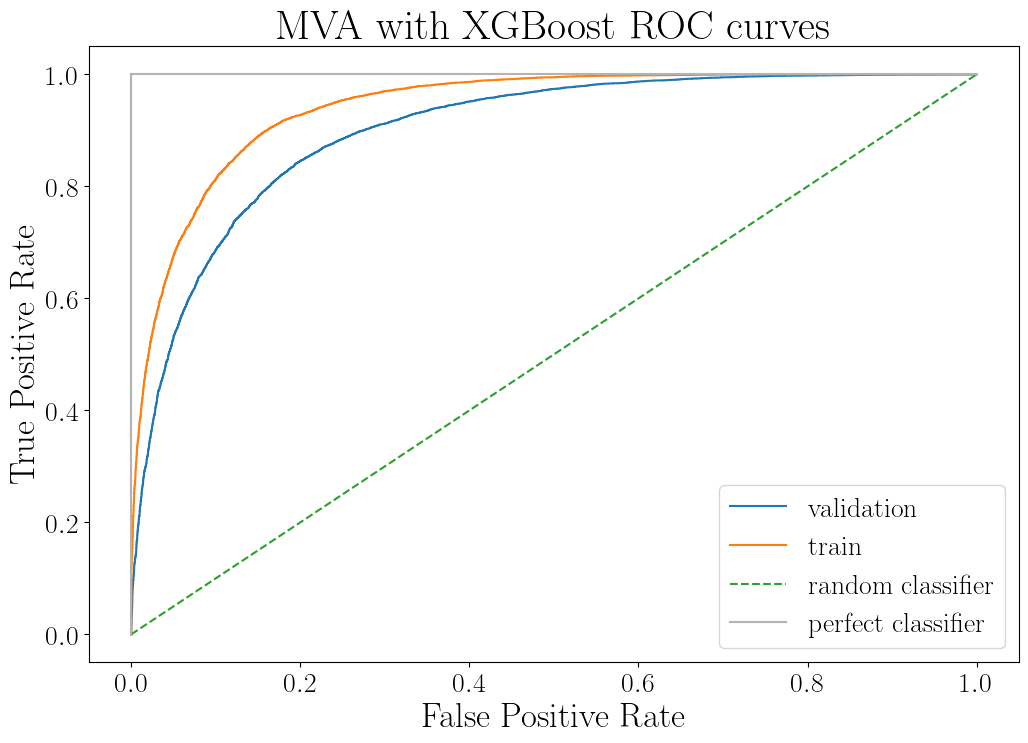

In [21]:
y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),roc_auc_score(y_valid, y_valid_pred)))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_valid, y_valid_pred)
false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_train_pred)
plt.figure(figsize=(12,8))
plt.title('MVA with XGBoost ROC curves')
plt.plot(false_positive_rate, true_positive_rate, label='validation')
plt.plot(false_positive_rate_train, true_positive_rate_train, label='train')
plt.plot([0, 1], ls="--", label='random classifier')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7", label='perfect classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend();

# 4 Hyperparameter tuning

In [22]:
learning_rate_list = [0.01, 0.02]
max_depth_list = [2, 3]
n_estimators_list = [1000]

params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

4


{'learning_rate': [0.01, 0.02], 'max_depth': [2, 3], 'n_estimators': [1000]}

Now let us pass this to GridSearchCV. We have a custom scoring function based on sklearn's roc_auc_score() which calculated area under the curve. CV value is 2, which is not ideal but we want to minimize the execution time.

def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgb.XGBClassifier(#subsample=0.5,
                                                                #colsample_bytree=0.25,
                                                                eval_metric='auc',
                                                                early_stopping_rounds=5),
                                                                #use_label_encoder=False),
                                param_grid=params_dict,
                                cv=[(ind_train, ind_valid)],
                                scoring=my_roc_auc_score,
                                return_train_score=True,
                                verbose=4)

model_xgboost_hp.fit(X, y, eval_set=[(X_train, y_train),(X_valid, y_valid)])

Let us look at the output of grid search step. We will retain only a few relevant columns and sort based on rank_test_score i.ee the performance on validation data

df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score','param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)
df_cv_results=df_cv_results.reset_index(drop=True)
df_cv_results['diff']=abs(df_cv_results['mean_train_score']-df_cv_results['mean_test_score'])
df_cv_results.sort_values(by='diff', inplace=True)
df_cv_results=df_cv_results.reset_index(drop=True)
df_cv_results

Grid search from scratch version:

In [23]:
df_GS_res=pd.DataFrame(columns=('learning rate', 'max depth', 'max tree', 'AUC train score', 'AUC test score', 'optimal n estimators'))
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])


for learning_rate in params_dict['learning_rate']:
    for max_depth in params_dict['max_depth']:
        for max_estimators in params_dict['n_estimators']:
            model_xgboost_it = xgb.XGBClassifier(  n_estimators=max_estimators,
                                    max_depth=max_depth,
                                    learning_rate=learning_rate,
                                    objective='binary:logistic',
                                    eval_metric='auc',
                                    early_stopping_rounds=10,
                                    verbosity=1)
            eval_set = [(X_valid, y_valid)]
            model_xgboost_it.fit(X_train,
                  y_train,
                  eval_set=eval_set,
                  verbose=True)
            auc_train_score=my_roc_auc_score(model_xgboost_it, X_train, y_train)
            auc_test_score=my_roc_auc_score(model_xgboost_it, X_valid, y_valid)
            new_row = pd.Series({'learning rate':learning_rate, 'max depth':max_depth, 'max tree':max_estimators, 'AUC train score':auc_train_score, 'AUC test score':auc_test_score, 'optimal n estimators':model_xgboost_it.best_iteration})
            df_GS_res=pd.concat([df_GS_res, new_row.to_frame().T],ignore_index=True)
df_GS_res['diff_AUC']=abs(df_GS_res['AUC train score']-df_GS_res['AUC test score'])

[0]	validation_0-auc:0.66773
[1]	validation_0-auc:0.66774
[2]	validation_0-auc:0.66774


[3]	validation_0-auc:0.68316
[4]	validation_0-auc:0.68315
[5]	validation_0-auc:0.68318
[6]	validation_0-auc:0.68315
[7]	validation_0-auc:0.68315
[8]	validation_0-auc:0.70341
[9]	validation_0-auc:0.70238
[10]	validation_0-auc:0.70382
[11]	validation_0-auc:0.70344
[12]	validation_0-auc:0.70402
[13]	validation_0-auc:0.70398
[14]	validation_0-auc:0.70812
[15]	validation_0-auc:0.71288
[16]	validation_0-auc:0.71272
[17]	validation_0-auc:0.71309
[18]	validation_0-auc:0.71314
[19]	validation_0-auc:0.71356
[20]	validation_0-auc:0.71323
[21]	validation_0-auc:0.71335
[22]	validation_0-auc:0.71332
[23]	validation_0-auc:0.71376
[24]	validation_0-auc:0.71386
[25]	validation_0-auc:0.72044
[26]	validation_0-auc:0.72024
[27]	validation_0-auc:0.72479
[28]	validation_0-auc:0.72540
[29]	validation_0-auc:0.72516
[30]	validation_0-auc:0.72615
[31]	validation_0-auc:0.72657
[32]	validation_0-auc:0.72686
[33]	validation_0-auc:0.72708
[34]	validation_0-auc:0.73058
[35]	validation_0-auc:0.73118
[36]	validation_0

In [24]:
df_GS_res.sort_values(by='diff_AUC', inplace=True)
df_GS_res=df_GS_res.reset_index(drop=True)
df_GS_res

,learning rate,max depth,max tree,AUC train score,AUC test score,optimal n estimators,diff_AUC
0,0.01,2.0,1000.0,0.881594,0.873005,999.0,0.008589
1,0.02,2.0,1000.0,0.896542,0.885178,999.0,0.011363
2,0.01,3.0,1000.0,0.903041,0.889425,999.0,0.013616
3,0.02,3.0,1000.0,0.915734,0.897026,999.0,0.018708


In [25]:
optimal_learning_rate=df_GS_res['learning rate'][0]
optimal_max_depth=int(df_GS_res['max depth'][0])
optimal_n_estimators=int(df_GS_res['max tree'][0])

It seems interesting to take worst ranking solution to fight the overtraining ???????????

In [26]:
print(optimal_learning_rate)
print(optimal_max_depth)
print(optimal_n_estimators)

0.01
2
1000


# 5 Final model

Using best parameter of the previous step.

In [27]:
model_xgboost_fin = xgb.XGBClassifier(learning_rate=optimal_learning_rate,
                                          max_depth=optimal_max_depth,
                                          n_estimators=optimal_n_estimators,
                                          #subsample=0.5,
                                          #colsample_bytree=0.25,
                                          early_stopping_rounds=10,#could be inteerseting
                                          eval_metric='auc',
                                          verbosity=1)#,
                                          #use_label_encoder=False)

# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_valid, y_valid)]

model_xgboost_fin.fit(X_train,
                  y_train,
                  #early_stopping_rounds=10,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.66793	validation_1-auc:0.66773


[1]	validation_0-auc:0.66794	validation_1-auc:0.66774
[2]	validation_0-auc:0.66794	validation_1-auc:0.66774
[3]	validation_0-auc:0.68460	validation_1-auc:0.68316
[4]	validation_0-auc:0.68461	validation_1-auc:0.68315
[5]	validation_0-auc:0.68456	validation_1-auc:0.68318
[6]	validation_0-auc:0.68461	validation_1-auc:0.68315
[7]	validation_0-auc:0.68461	validation_1-auc:0.68315
[8]	validation_0-auc:0.70516	validation_1-auc:0.70341
[9]	validation_0-auc:0.70401	validation_1-auc:0.70238
[10]	validation_0-auc:0.70555	validation_1-auc:0.70382
[11]	validation_0-auc:0.70521	validation_1-auc:0.70344
[12]	validation_0-auc:0.70579	validation_1-auc:0.70402
[13]	validation_0-auc:0.70574	validation_1-auc:0.70398
[14]	validation_0-auc:0.70975	validation_1-auc:0.70812
[15]	validation_0-auc:0.71381	validation_1-auc:0.71288
[16]	validation_0-auc:0.71415	validation_1-auc:0.71272
[17]	validation_0-auc:0.71471	validation_1-auc:0.71309
[18]	validation_0-auc:0.71441	validation_1-auc:0.71314
[19]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

# 6 Evaluation of the optimal model

Let us find out the performance of the final model by calculating AUC value on training and validation sets + plotting the ROC curves

Cell to save the model

In [156]:
#model_xgboost_fin.save_model("model_XGB.json")

I order to load the saved model (to redo some plots):

In [33]:
#model_xgboost_fin = xgb.XGBClassifier()
#model_xgboost_fin.load_model("model_XGB.json")

AUC Train: 0.8749
AUC Valid: 0.8747


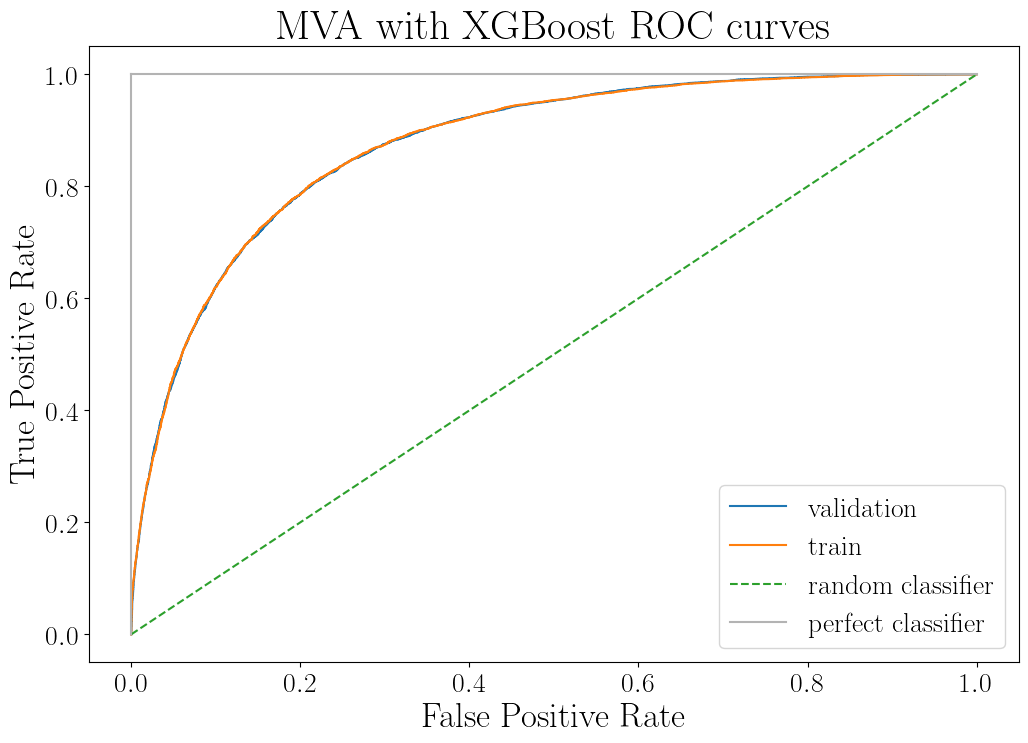

In [34]:
y_valid_pred = model_xgboost_fin.predict_proba(X_valid)[:,1]
y_train_pred = model_xgboost_fin.predict_proba(X_train)[:,1]
print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),roc_auc_score(y_valid, y_valid_pred)))
false_positive_rate, true_positive_rate, threshold = roc_curve(y_valid, y_valid_pred)
false_positive_rate_train, true_positive_rate_train, threshold_train = roc_curve(y_train, y_train_pred)
plt.figure(figsize=(12,8))
plt.title('MVA with XGBoost ROC curves')
plt.plot(false_positive_rate, true_positive_rate, label='validation')
plt.plot(false_positive_rate_train, true_positive_rate_train, label='train')
plt.plot([0, 1], ls="--", label='random classifier')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7", label='perfect classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend();


Let us print model performance w.r.t number of trees. The first step is to get AUC values on training and validation dataset for every value of the tree. We can use eval_result() function to get that. Then we can go ahead and plot it.

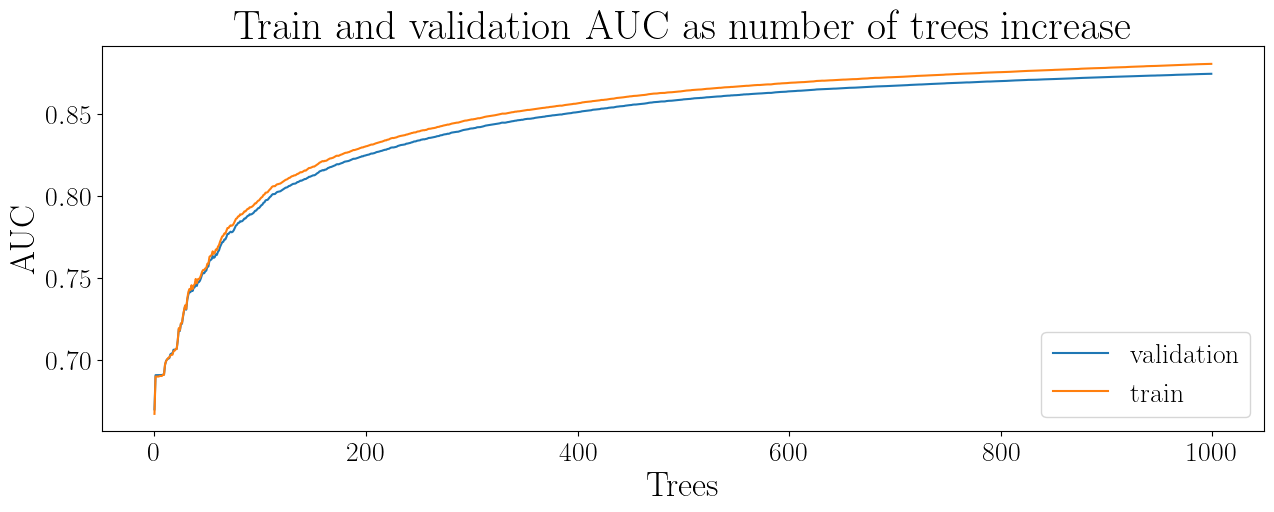

In [35]:
evaluation_results = model_xgboost_fin.evals_result()

# Index into each key to find AUC values for training and validation data after each tree
train_auc_tree = evaluation_results['validation_0']['auc']
valid_auc_tree = evaluation_results['validation_1']['auc']


# Plotting Section
plt.figure(figsize=(15,5))

plt.plot(valid_auc_tree, label='validation')
plt.plot(train_auc_tree, label='train')
#plt.ylim(0,1)
plt.title("Train and validation AUC as number of trees increase")
plt.xlabel("Trees")
plt.ylabel("AUC")
plt.legend(loc='lower right');

Looking for overtraining:

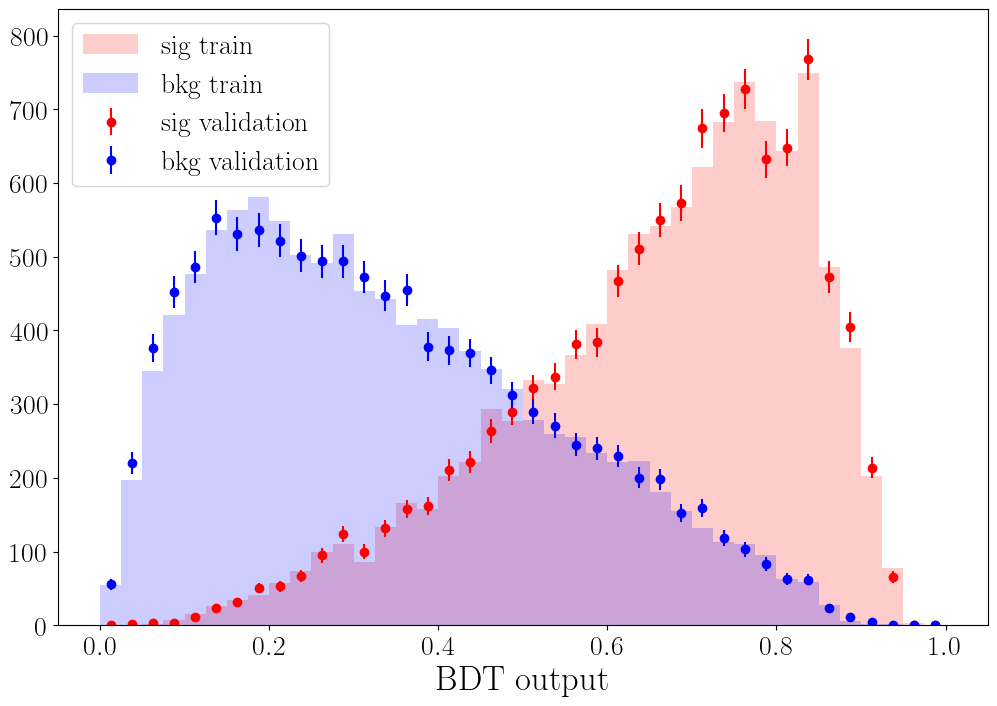

In [36]:
minSig=np.min([len(y_valid[y_valid==1]),len(y_train[y_train==1])])-1

binning=np.linspace(0,1,41)
plt.figure(figsize=(12,8))
plt.hist(y_train_pred[y_train==1][:minSig],bins=binning, color='red', alpha=0.2, label='sig train')
plt.hist(y_train_pred[y_train==0][:minSig],bins=binning, color='blue', alpha=0.2, label='bkg train')
COUNTS_sig,bin_edges = np.histogram(y_valid_pred[y_valid==1][:minSig],binning)
COUNTS_bkg,bin_edges = np.histogram(y_valid_pred[y_valid==0][:minSig],binning)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
err_sig = np.sqrt(COUNTS_sig)
err_bkg = np.sqrt(COUNTS_bkg)
plt.errorbar(bin_centers, COUNTS_sig, yerr=err_sig, fmt='ro',label='sig validation')
plt.errorbar(bin_centers, COUNTS_bkg, yerr=err_bkg, fmt='bo',label='bkg validation')
plt.legend()
plt.xlabel("BDT output");


In [31]:
print(len(y_train[y_train==1][:minSig]))
print(len(y_valid[y_valid==1][:minSig]))

print(len(y_train[y_train==0]))
print(len(y_valid[y_valid==0]))

print(y_valid_pred)

10831
10831
10832
10942
[0.46695712 0.53942364 0.3946945  ... 0.68096036 0.7586     0.04242446]


y_valid_pred.sort()
y_train_pred.sort()


In [38]:
print('Kolomogorov Smirnov test on signal : {}'.format(ks_2samp(y_train_pred[y_train==1][:minSig], y_valid_pred[y_valid==1][:minSig])))
print('Kolomogorov Smirnov test on backgrounds : {}'.format(ks_2samp(y_train_pred[y_train==0][:minSig], y_valid_pred[y_valid==0][:minSig])))

Kolomogorov Smirnov test on signal : KstestResult(statistic=0.006370602899085975, pvalue=0.9795091788828572, statistic_location=0.6487859, statistic_sign=1)
Kolomogorov Smirnov test on backgrounds : KstestResult(statistic=0.010617671498476589, pvalue=0.5709686498343104, statistic_location=0.14985114, statistic_sign=-1)


Apply MVA to full data (cut window):

In [39]:
model_xgboost_fin = xgb.XGBClassifier()
model_xgboost_fin.load_model("model_XGB.json")
feature_columns=['B_FD', 'p_Kst', 'p_pi_max_tau_1', 'p_pi_min_tau_1', 'p_tau_1', 'p_pi_max_tau_2', 'p_pi_min_tau_2', 'p_tau_2', 'tau1_FD', 'tau1_PV_FD', 'tau2_FD', 'tau2_PV_FD', 'tau_1_m2pi_max', 'tau_1_m2pi_min', 'tau_1_m3pi', 'tau_2_m2pi_max', 'tau_2_m2pi_min', 'tau_2_m3pi', 'P_tau_1', 'P_tau_2']

dfcutwindow=df
dfcutwindow['class_pred']=model_xgboost_fin.predict_proba(dfcutwindow.loc[:,feature_columns])[:,1]

feature_columns=['B_FD', 'p_Kst', 'p_pi_max_tau_1', 'p_pi_min_tau_1', 'p_tau_1', 'p_pi_max_tau_2', 'p_pi_min_tau_2', 'p_tau_2', 'tau1_FD', 'tau1_PV_FD', 'tau2_FD', 'tau2_PV_FD', 'tau_1_m2pi_max', 'tau_1_m2pi_min', 'tau_1_m3pi', 'tau_2_m2pi_max', 'tau_2_m2pi_min', 'tau_2_m3pi', 'P_tau_1', 'P_tau_2']

dfcutwindow=df
dfcutwindow['class_pred']=model_xgboost_fin.predict_proba(dfcutwindow.loc[:,feature_columns])[:,1]

Performance measurements on cut study window:

In [40]:
smearing='20-3'
i='sel'
denom_purity=0
for mode in listmod:
    data[f"{mode}_{smearing}"][f"{i}_cut_study_eff_XGB"]=len(dfcutwindow[(dfcutwindow['decay_mode']==f'{mode}')&(dfcutwindow['class_pred']>0.5)])/len(dfcutwindow[dfcutwindow['decay_mode']==f'{mode}'])
    data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number_after_XGB"]=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"]*data[f"{mode}_{smearing}"][f"{i}_cut_study_eff_XGB"]
    denom_purity+=data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number_after_XGB"]
    print("{} eff XGB cut : {:.3f}, true number before | after cut : {:.3f} | {:.3f}".format(mode, data[f"{mode}_{smearing}"][f"{i}_cut_study_eff_XGB"], data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number"],data[f"{mode}_{smearing}"][f"{i}_cut_study_true_number_after_XGB"]))
purity=data[f"sig_{smearing}"][f"{i}_cut_study_true_number_after_XGB"]/denom_purity
print(f"Purity after XGB cut on [5,5.6]GeV window : {purity}")

sig eff XGB cut : 0.815, true number before | after cut : 100.016 | 81.500
Bd2KstDsDsDs2TauNu eff XGB cut : 0.328, true number before | after cut : 32.947 | 10.800
Bd2KstDsDsDs2pipipipi0 eff XGB cut : 0.072, true number before | after cut : 0.087 | 0.006
Bd2KstDsTauNuDs2TauNu eff XGB cut : 0.471, true number before | after cut : 123.222 | 58.059
Bd2KstDsDsDs2pipipipi0pi0 eff XGB cut : 0.061, true number before | after cut : 37.871 | 2.296
Bd2KstDsstDsDsst2DsgammaDs2Taunu eff XGB cut : 0.164, true number before | after cut : 62.186 | 10.174
Bd2KstDsDsDs2TaunuDs2pipipipi0 eff XGB cut : 0.220, true number before | after cut : 1.684 | 0.371
Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 eff XGB cut : 0.171, true number before | after cut : 165.929 | 28.370
Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 eff XGB cut : 0.196, true number before | after cut : 37.006 | 7.247
Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 eff XGB cut : 0.021, true number before | after cut : 62.473 | 1.329
Purity after XGB cut on [5,5.

Apply MVA to full data (plot window):

In [41]:
dfplotcut=dfplot
dfplotcut['class_pred']=model_xgboost_fin.predict_proba(dfplotcut.loc[:,feature_columns])[:,1]

Performance measurements on plot window:

In [42]:
smearing='20-3'
i='sel'
denom_purity=0
for mode in listmod:
    data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"]=len(dfplotcut[(dfplotcut['decay_mode']==f'{mode}')&(dfplotcut['class_pred']>0.5)])/len(dfplotcut[dfplotcut['decay_mode']==f'{mode}'])
    data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]=data[f"{mode}_{smearing}"][f"{i}_plot_true_number"]*data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"]
    denom_purity+=data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]
    print("{} eff XGB cut : {:.3f}, true number before | after cut : {:.3f} | {:.3f}".format(mode, data[f"{mode}_{smearing}"][f"{i}_plot_eff_XGB"], data[f"{mode}_{smearing}"][f"{i}_plot_true_number"],data[f"{mode}_{smearing}"][f"{i}_plot_true_number_after_XGB"]))
    data[f"{mode}_{smearing}"][f"{i}_plot_after_XGB"]=dfplotcut['mass'][(dfplotcut['decay_mode']==f'{mode}')&(dfplotcut['class_pred']>0.5)]
purity=data[f"sig_{smearing}"][f"{i}_plot_true_number_after_XGB"]/denom_purity
print(f"Purity after XGB cut on plot window : {purity}")

sig eff XGB cut : 0.781, true number before | after cut : 115.887 | 90.512
Bd2KstDsDsDs2TauNu eff XGB cut : 0.609, true number before | after cut : 157.964 | 96.143
Bd2KstDsDsDs2pipipipi0 eff XGB cut : 0.065, true number before | after cut : 0.373 | 0.024
Bd2KstDsTauNuDs2TauNu eff XGB cut : 0.654, true number before | after cut : 459.250 | 300.328
Bd2KstDsDsDs2pipipipi0pi0 eff XGB cut : 0.131, true number before | after cut : 127.423 | 16.744
Bd2KstDsstDsDsst2DsgammaDs2Taunu eff XGB cut : 0.587, true number before | after cut : 507.077 | 297.695
Bd2KstDsDsDs2TaunuDs2pipipipi0 eff XGB cut : 0.334, true number before | after cut : 7.660 | 2.555
Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 eff XGB cut : 0.422, true number before | after cut : 896.262 | 377.801
Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 eff XGB cut : 0.381, true number before | after cut : 141.935 | 54.051
Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 eff XGB cut : 0.112, true number before | after cut : 400.943 | 44.977
Purity after XGB c

smearing='20_3'
soltype='sel'
if (soltype=='rr/--'):
    solsig='rr'
    solbkg='--'
else:
    solsig=soltype
    solbkg=soltype
low = 4.6
high = 6
low3=5.1
high3=5.7
low1=5.26
high1=5.3
low2=5.2
high2=5.5
obs = zfit.Space('mB', limits=(low, high))

#PDF
rand += 1
#Crystal Ball parameters
mu = zfit.Parameter(f"mu_{rand}", lp.B_0.mass/100., low, high)#why /100 ?
sigma = zfit.Parameter(f"sigma_{rand}", 0.04, 0.025, 0.2)
alphaL = zfit.Parameter(f"alphaL_{rand}", 0.2, 0., 5.)
nL = zfit.Parameter(f"nL_{rand}", 10., 0., 200.)
alphaR = zfit.Parameter(f"alphaR_{rand}", -0.2, -5., 0.)
nR = zfit.Parameter(f"nR_{rand}", 10., 0., 200.)
# Core gaussian parameters
mu1 = zfit.Parameter(f"mu1_{rand}", lp.B_0.mass/100., low1, high1)
sigmaG1 = zfit.Parameter(f"sigma1_{rand}", 0.015, 0., 1)
# Fractions
frac = zfit.Parameter(f"frac_{rand}", 0.5, 0., 1.)
frac_CB = zfit.Parameter(f"frac_CB{rand}", 0.5, 0., 1.)



pdf_sigL = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaL, n=nL)
pdf_sigR = zfit.pdf.CrystalBall(obs=obs, mu=mu, sigma=sigma, alpha=alphaR, n=nR)

pdf_sigG1=zfit.pdf.Gauss(obs=obs, mu=mu1, sigma=sigmaG1)

pdf_int_CBs = zfit.pdf.SumPDF([pdf_sigL, pdf_sigR], frac_CB)
pdf = zfit.pdf.SumPDF([pdf_int_CBs, pdf_sigG1], frac)

data_np = np.array(data[f"sig_{smearing}"][f"{solsig}_plot"])
data_low_cut = data_np >= low
data_high_cut = data_np <= high
data_cut = np.logical_and(data_low_cut, data_high_cut)
data_np = data_np[data_cut]
datazf = zfit.Data.from_numpy(obs=obs, array=data_np)

nll = zfit.loss.UnbinnedNLL(model=pdf, data=datazf)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
param_errors = result.hesse()

print("Fit function minimum:", result.fmin)
print("Fit converged:", result.converged)
print("Fit full minimizer information:", result.info)

params = result.params
print(params);

Expected number of events in window is 90.51229440000002
Expected number of Bd2KstDsDsDs2TauNu in window is 96.14313801659728
Expected number of Bd2KstDsDsDs2pipipipi0 in window is 0.024289897464410747
Expected number of Bd2KstDsTauNuDs2TauNu in window is 300.3280311390457
Expected number of Bd2KstDsDsDs2pipipipi0pi0 in window is 16.744330627276433
Expected number of Bd2KstDsstDsDsst2DsgammaDs2Taunu in window is 297.6954027417496
Expected number of Bd2KstDsDsDs2TaunuDs2pipipipi0 in window is 2.5549850008664765
Expected number of Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0 in window is 377.8010992007548
Expected number of Bd2KstDsDsDs2TaunuDs2pipipipi0pi0 in window is 54.050902273371776
Expected number of Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0 in window is 44.976883570879124


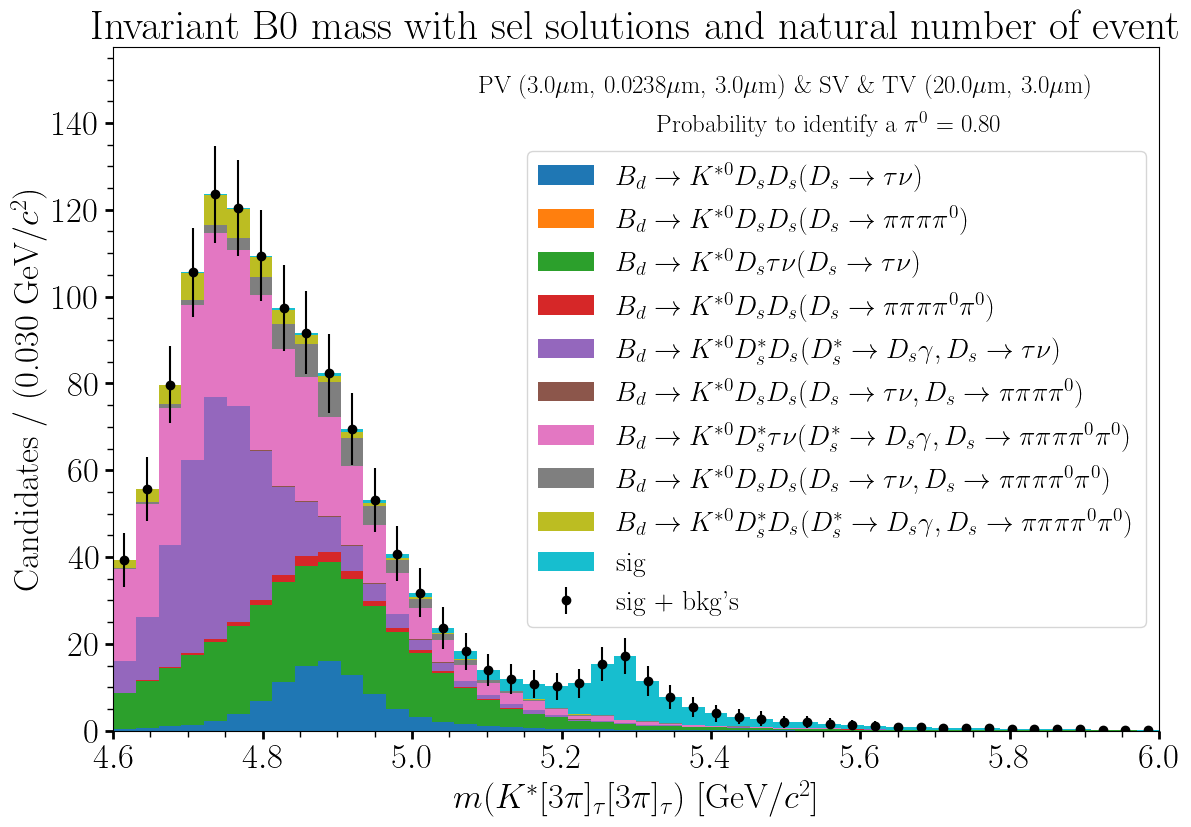

In [43]:
low = 4.6
high = 6

smearing='20-3'
soltype='sel'
if (soltype=='rr/--'):
    solsig='rr'
    solbkg='--'
else:
    solsig=soltype
    solbkg=soltype
PV_smear=True
SV_smear=True
TV_smear=True
PV_scale=3e-3
SV_scale=20e-3
TV_scale=3e-3

data_np = np.array(data[f"sig_{smearing}"][f"{solsig}_plot_after_XGB"])
labelTeX={"Bd2KstDsDsDs2TauNu":"$B_d\\to K^{*0}D_sD_s(D_s\\to \\tau\\nu)$","Bd2KstDsDsDs2pipipipi0":"$B_d\\to K^{*0}D_sD_s(D_s\\to \\pi\\pi\\pi\\pi^0)$", "Bd2KstDsTauNuDs2TauNu":"$B_d\\to K^{*0}D_s\\tau\\nu(D_s\\to \\tau\\nu)$","Bd2KstDsDsDs2pipipipi0pi0":"$B_d\\to K^{*0}D_sD_s(D_s\\to \\pi\\pi\\pi\\pi^0\\pi^0)$", "Bd2KstDsstDsDsst2DsgammaDs2Taunu":"$B_d\\to K^{*0}D_s^*D_s(D_s^*\\to D_s\\gamma, D_s\\to \\tau\\nu)$","Bd2KstDsDsDs2TaunuDs2pipipipi0":"$B_d\\to K^{*0}D_sD_s(D_s\\to \\tau\\nu, D_s\\to\\pi\\pi\\pi\\pi^0)$","sig":"sig","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0":"$B_d\\to K^{*0}D_s^*\\tau\\nu(D_s^*\\to D_s\\gamma, D_s\\to \\pi\\pi\\pi\\pi^0\\pi^0)$","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0":"$B_d\\to K^{*0}D_sD_s(D_s\\to \\tau\\nu, D_s\\to\\pi\\pi\\pi\\pi^0\\pi^0)$", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0":"$B_d\\to K^{*0}D_s^*D_s(D_s^*\\to D_s\\gamma, D_s\\to \\pi\\pi\\pi\\pi^0\\pi^0)$"}

fig, ax = plt.subplots(figsize=(12,8))
n = len(data_np)
bins = 2*int(np.sqrt(n))

bins=int((6-4.6)/0.03)
bin_w = (high - low)/bins

bng=np.linspace(low,high,bins)

units = "GeV/$c^2$"
counts, bin_edges = np.histogram(data_np, bins, range=(low,high))
true_number=data[f"sig_{smearing}"][f"{solsig}_plot_true_number_after_XGB"]
print('Expected number of events in window is {}'.format(true_number))
rescale=(true_number/np.sum(counts))#signal scale factor to consider a realist number of events
data[f"sig_{smearing}"][f"{solsig}_rescale"]=rescale
counts=counts*rescale
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)

listbkg=["Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0"]
for mode in listbkg:
    print('Expected number of {} in window is {}'.format(mode,data[f"{mode}_{smearing}"][f"{solbkg}_plot_true_number_after_XGB"]))
countstot=counts
errtot=err**2
for mode in listbkg:
    counst_bkg, bin_edges_bkg=np.histogram(data[f"{mode}_{smearing}"][f"{solbkg}_plot_after_XGB"], bins, range=(low,high))
    data[f"{mode}_{smearing}"][f"{solbkg}_rescale"]=data[f"{mode}_{smearing}"][f"{solbkg}_plot_true_number_after_XGB"]/np.sum(counst_bkg)
    counst_bkg=counst_bkg*data[f"{mode}_{smearing}"][f"{solbkg}_rescale"]
    countstot+=counst_bkg
    err_bkg=np.sqrt(counst_bkg)
    errtot+=err_bkg**2
errtot=np.sqrt(errtot)

data_hist=[]
labellist=["Bd2KstDsDsDs2TauNu","Bd2KstDsDsDs2pipipipi0","Bd2KstDsTauNuDs2TauNu","Bd2KstDsDsDs2pipipipi0pi0","Bd2KstDsstDsDsst2DsgammaDs2Taunu","Bd2KstDsDsDs2TaunuDs2pipipipi0","Bd2KstDsstTauNuDsst2DsgammaDs2pipipipi0pi0","Bd2KstDsDsDs2TaunuDs2pipipipi0pi0", "Bd2KstDsstDsDsst2DsgammaDs2PiPiPiPi0Pi0","sig"]
weights_list=[]
for mode in labellist:
    if (mode=='sig'):
        i=solsig
    else:
        i=solbkg
    data_hist.append(data[f"{mode}_{smearing}"][f"{i}_plot_after_XGB"])
    weights_list.append(np.ones(len(data[f"{mode}_{smearing}"][f"{i}_plot_after_XGB"]))*data[f"{mode}_{smearing}"][f"{i}_rescale"])

plt.hist(data_hist,bin_edges, stacked=True, weights=weights_list,label=list(map(labelTeX.__getitem__, labellist)))
plt.errorbar(bin_centres, countstot, yerr=errtot, fmt='o', label='sig + bkg\'s', color="black")

ax.tick_params(axis='both', which='major', labelsize=25,width=2,length=6)
ax.tick_params(axis='both', which='minor',width=1,length=4)
plt.ylabel("Candidates / (%.3f GeV/$c^2$)" % bin_w,fontsize=25)
plt.xlabel("$m(K^* [3\pi]_\\tau [3\pi]_\\tau)$ [GeV/$c^2$]",fontsize=25)
plt.xlim(low,high)
ymin, ymax = plt.ylim(0, 150)
YMIN, YMAX = plt.ylim(0,1.05*ymax)#in order to keep same y window  in the following 
ax.xaxis.set_minor_locator(tick.AutoMinorLocator())
ax.yaxis.set_minor_locator(tick.AutoMinorLocator())
if ((PV_smear==False)&(SV_smear==False)&(TV_smear==False)):
    plt.text((high-low)*0.52+low,0.98*ymax,"TRUE DECAY VERTICES USED",fontsize=18)
if ((PV_smear==True)&(SV_smear==False)&(TV_smear==False)):
    plt.text((high-low)*0.52+low,0.98*ymax,f"PRIMARY VERTEX ({PV_scale*1000}$\mu$m) SMEARED",fontsize=18)
if ((PV_smear==False)&(SV_smear==True)&(TV_smear==False)):
    plt.text((high-low)*0.55+low,0.82*ymax,"\\textbf{SECONDARY VERTEX SMEARED}",fontsize=18)
if ((PV_smear==False)&(SV_smear==False)&(TV_smear==True)):
    plt.text((high-low)*0.55+low,0.82*ymax,"\\textbf{TERTIARY VERTEX SMEARED}",fontsize=18)
if ((PV_smear==True)&(SV_smear==True)&(TV_smear==False)):
    plt.text((high-low)*0.55+low,0.82*ymax,"\\textbf{PV \& SV SMEARED}",fontsize=18)
if ((PV_smear==True)&(SV_smear==False)&(TV_smear==True)):
    plt.text((high-low)*0.55+low,0.82*ymax,"\\textbf{PV \& TV SMEARED}",fontsize=18)
if ((PV_smear==False)&(SV_smear==True)&(TV_smear==True)):
    plt.text((high-low)*0.55+low,0.82*ymax,"\\textbf{SV \& TV SMEARED}",fontsize=18)
if ((PV_smear==True)&(SV_smear==True)&(TV_smear==True)):
    plt.text((high-low)*0.35+low,0.98*ymax,f"PV (3.0$\mu$m, 0.0238$\mu$m, 3.0$\mu$m)"+f" \& SV \& TV ({SV_scale*1000}$\mu$m, {TV_scale*1000}$\mu$m)",fontsize=18)
plt.text((high-low)*0.52+low,0.92*ymax,"Probability to identify a $\\pi^0$ = %.2f " % probpi0k,fontsize=18)
plt.tight_layout()
plt.title(f"Invariant B0 mass with {soltype} solutions and natural number of event")
plt.legend(loc='right')

string_proba=str(probpi0k)

if(SAVEMOD=="yes"):
    plt.savefig(f'new_vertexing_final_plots/rr_--_20_3_{string_proba}.pdf');
#mask_centre=(bin_centres>=5.2)&(bin_centres<=5.4)
#mask_centre1=(bin_centres>=5.2)&(bin_centres<=5.4)
#print(np.sum(counts[mask_centre])/np.sum(counts1[mask_centre1]))
#print(np.sum(counts1[mask_centre1])/np.sum(counts[mask_centre]))
#plot RMS evolution of the distribution (with ROOT ?)
#print(data[f"sig_20_3"][f"SV_{SVMOD}_eff_reco"][0], data[f"Bd2KstDsDsDs2pipipipi0_20_3"][f"SV_{SVMOD}_eff_reco"][0], data[f"Bd2KstDsDsDs2TauNu_20_3"][f"SV_{SVMOD}_eff_reco"][0])

In [58]:
dico={'a':'aa', 'b':'bb', 'c':'cc'}
listdico=['a','b','c']
list(map(dico.__getitem__, listdico))

['aa', 'bb', 'cc']

for LHCb: